In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score

In [21]:
df = pd.read_csv("../resources/data/nab/nab_cpu_utilization_cc0c53/rds_cpu_utilization_cc0c53.csv")

In [22]:
print "Data Range"
print "Start Date %s"%(df.head(1)['timestamp'])
print "End Date %s"%(df.tail(1)['timestamp'])

Data Range
Start Date 0    2014-02-14 14:30:00
Name: timestamp, dtype: object
End Date 4031    2014-02-28 14:30:00
Name: timestamp, dtype: object


In [23]:
print "num_values: %s"%(df.shape[0])

num_values: 4032


In [24]:
class SetColAsIndex(TransformerMixin):
    def __init__(self, col):
        self.col = col

    def transform(self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterCompleteDays(TransformerMixin):
    def __init__(self, n=96):
        self.n = n

    def transform(self, X, **transform_params):
        #print X.groupby(X.index.date).transform('count')
        X = X.ix[X.groupby(X.index.date).transform('count').iloc[:, 0] >= self.n]
        return X

    def fit(self, X, y=None, **fit_params):
        return self

class FilterDays(TransformerMixin):
    def __init__(self, days=None):
        self.days = days

    def transform(self, X, **transform_params):
        X = X.iloc[pd.Series(X.index.day).isin(self.days).values, :]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterWeekEnd(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X[X.index.weekday > 4]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class SortTimeSeries(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index()
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class RemoveDuplicateRow(TransformerMixin):
    def __init__(self, sample_period):
        self.sample_period = sample_period

    def transform(self, X, **transform_params):
        X = X.resample(self.sample_period, 'mean').fillna(method='bfill')
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [25]:
process_pipeline = make_pipeline(SetColAsIndex('timestamp'),
                                SortTimeSeries())
df = process_pipeline.fit_transform(df)
df = df.drop('timestamp', 1)

In [26]:
#add anomaly column
df['anomaly'] = 0
anomalies = [ "2014-02-25 07:15:00","2014-02-27 00:50:00"]
for anomaly_date in anomalies:
    df.set_value(anomaly_date,'anomaly', 1)
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    print row[0],row[1],row[2]

2014-02-25 07:15:00 25.1033 1
2014-02-27 00:50:00 19.165 1


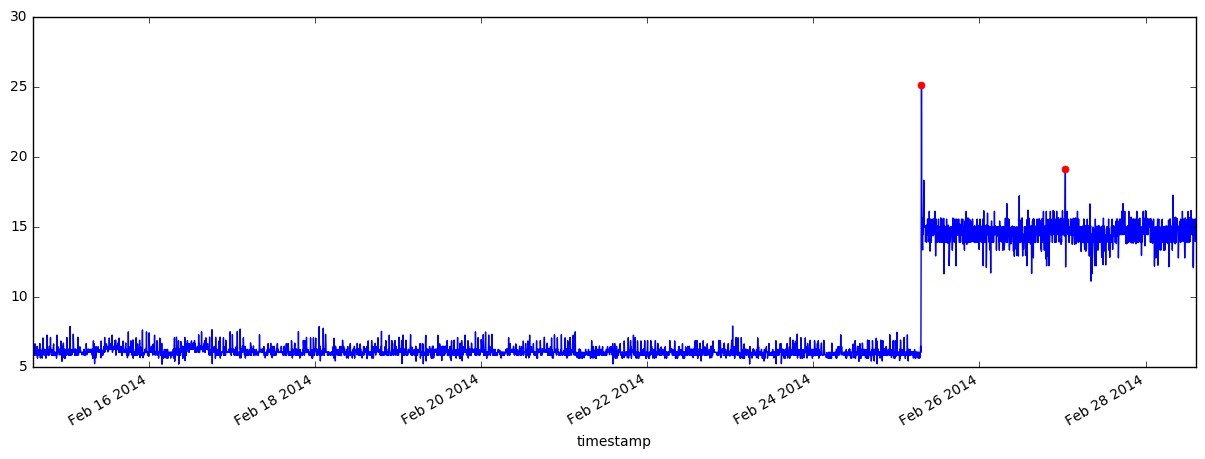

In [27]:
plt.figure()
df['value'].plot(figsize=(15,5))
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=10.0)
plt.show()

Size of test: 1038
Size of validation1: 576
Size of validation2: 1038
Size of train: 2418
Total: 5070
Ratio of test: 0.204734
Ratio of validation1: 0.113609
Ratio of validation2: 0.204734
Ratio of train: 0.476923
Pandas(Index=Timestamp('2014-02-25 07:15:00'), value=25.103300000000001, anomaly=1)
Pandas(Index=Timestamp('2014-02-27 00:50:00'), value=19.164999999999999, anomaly=1)


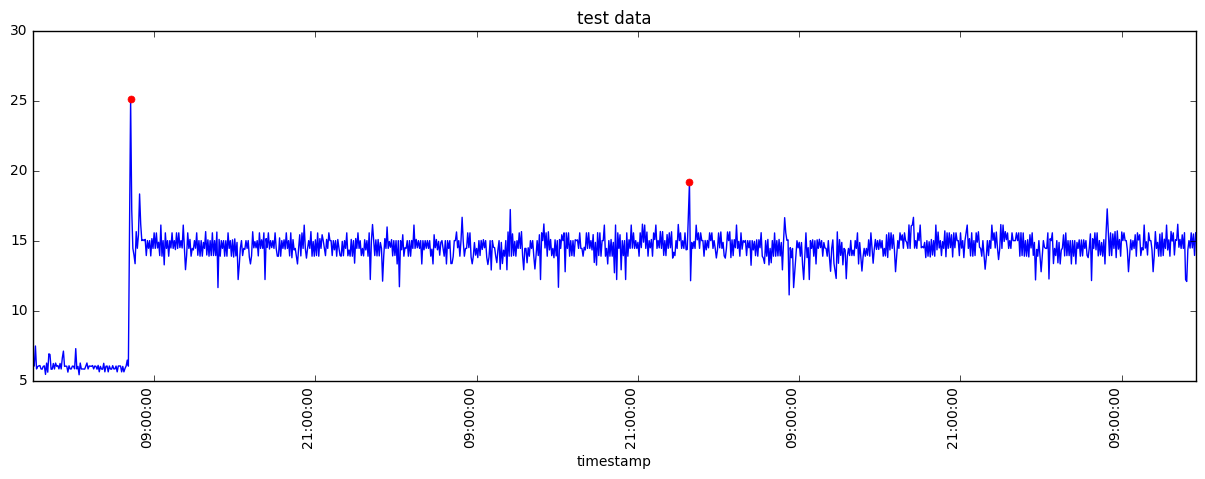

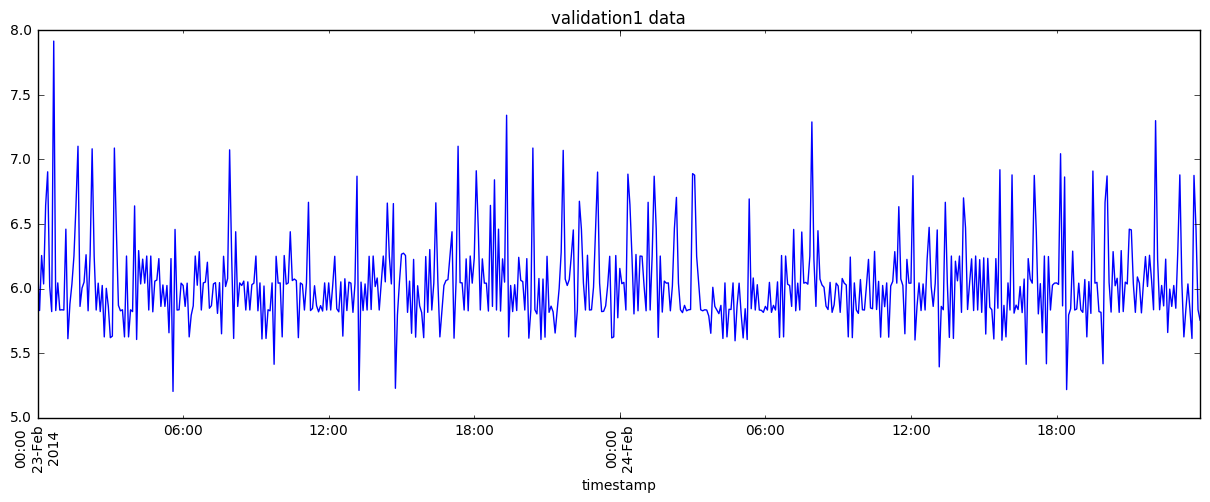

Pandas(Index=Timestamp('2014-02-25 07:15:00'), value=25.103300000000001, anomaly=1)
Pandas(Index=Timestamp('2014-02-27 00:50:00'), value=19.164999999999999, anomaly=1)


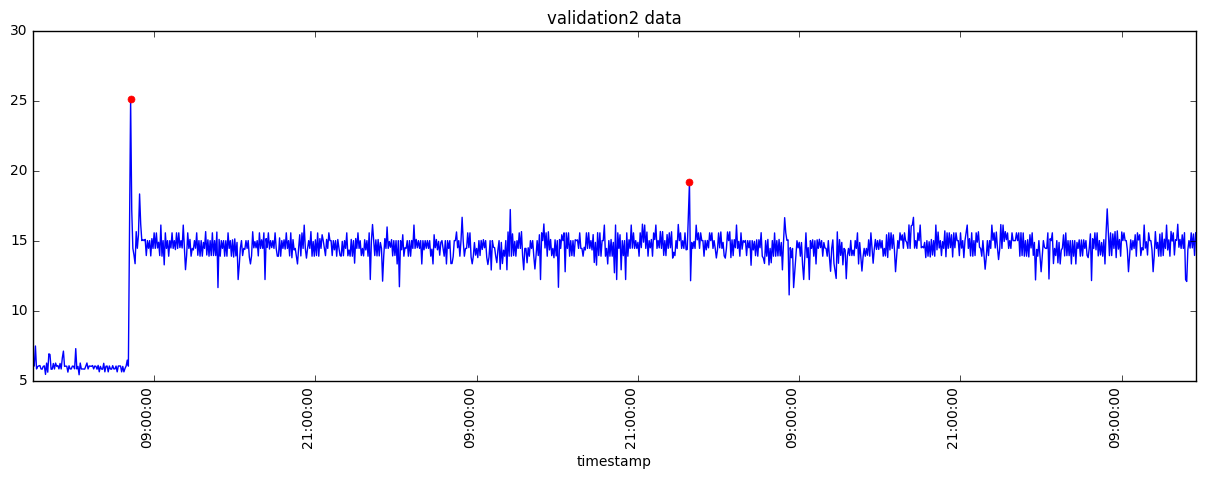

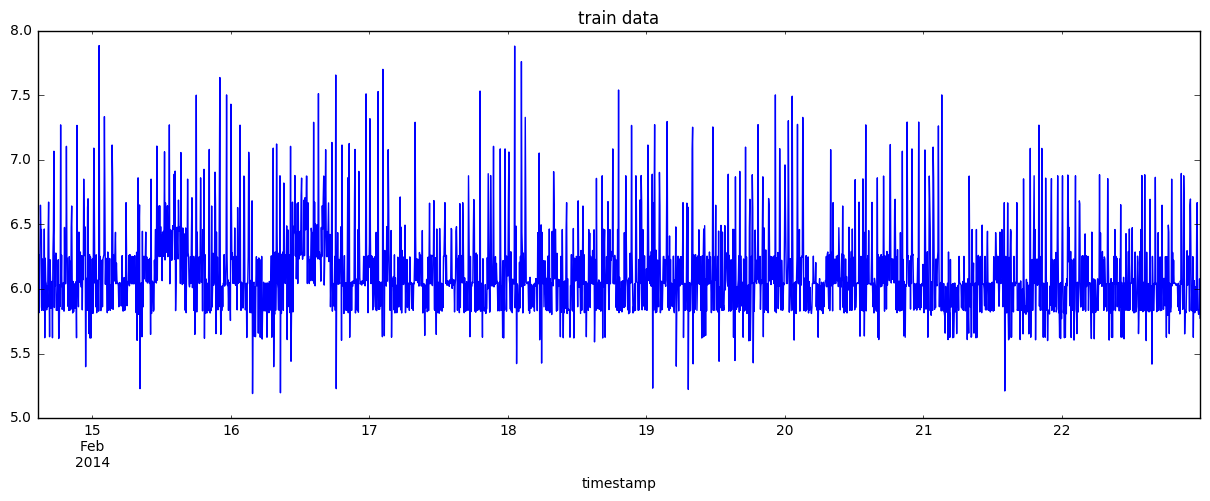

In [28]:

# here make validation2 and test same because of 2 anomalies
df_validation_prediction =df['2014-02-23':'2014-02-24']
df_test = df['2014-02-25':]
df_validation_anomaly = df['2014-02-25':]
#Since df_validation_anomaly and test are equal because
df_not_train = pd.concat([df_validation_prediction,df_validation_anomaly])
df_train = df[~df.isin(df_not_train)].dropna()

df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation_prediction
df_dict['validation2'] = df_validation_anomaly

count = 0
for key in df_dict:
    print "Size of %s: %d"%(key,df_dict[key].shape[0])
    count += df_dict[key].shape[0]
print "Total: %d"%(count)

for key in df_dict:
    print "Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count)

    
for key in df_dict:
    df_tmp = df_dict[key]
    plt.figure()
    df_tmp['value'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        print row
        plt.plot(row[0], row[1], 'r.', markersize=10.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [29]:
for key in df_dict:
    np.save("../resources/data/nab/nab_cpu_utilization_cc0c53/%s"%(key),df_dict[key])

In [30]:
train = np.load("../resources/data/nab/nab_cpu_utilization_cc0c53/train.npy")
validation1 = np.load("../resources/data/nab/nab_cpu_utilization_cc0c53/validation1.npy")
validation2 = np.load("../resources/data/nab/nab_cpu_utilization_cc0c53/validation2.npy")
test = np.load("../resources/data/nab/nab_cpu_utilization_cc0c53/test.npy")
test_orig = test

In [31]:
print sum(train[:,1])
print sum(validation1[:,1])
print sum(validation2[:,1])
print sum(test[:,1])

0.0
0.0
2.0
2.0


In [32]:
#Detection code starts here
#Detection code starts here
#Detection code starts here
#Detection code starts here

In [33]:
data_folder = "../resources/data/nab/nab_cpu_utilization_cc0c53/"

In [34]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print train_predictions.shape
print train_true.shape


(2353, 1)
(2353,)


In [35]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print np.shape(validation2_predictions)
print np.shape(validation2_true)
print np.shape(validation2_labels)
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print np.shape(validation2_labels)


(973, 1)
(973,)
(973, 1, 1)
(973, 1)


In [36]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print np.shape(test_predictions)
print np.shape(test_true)
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print np.shape(test_labels)

(973, 1)
(973,)
(973, 1)


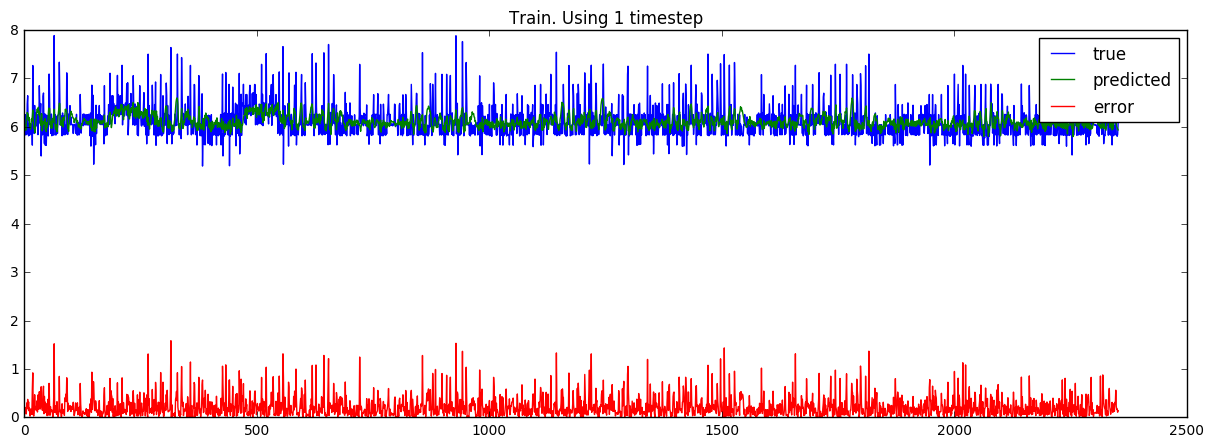

In [37]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[ 0.00941006]
0.0972291403301


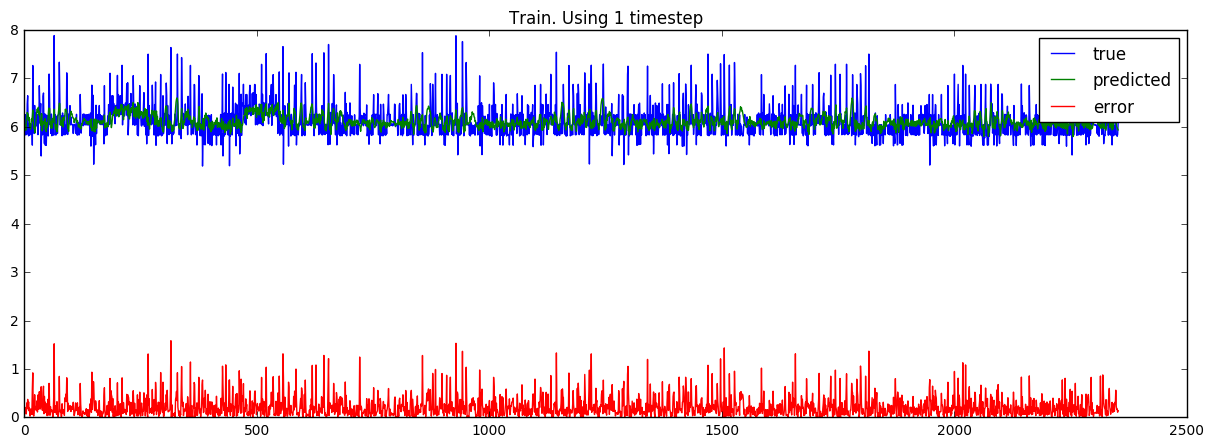

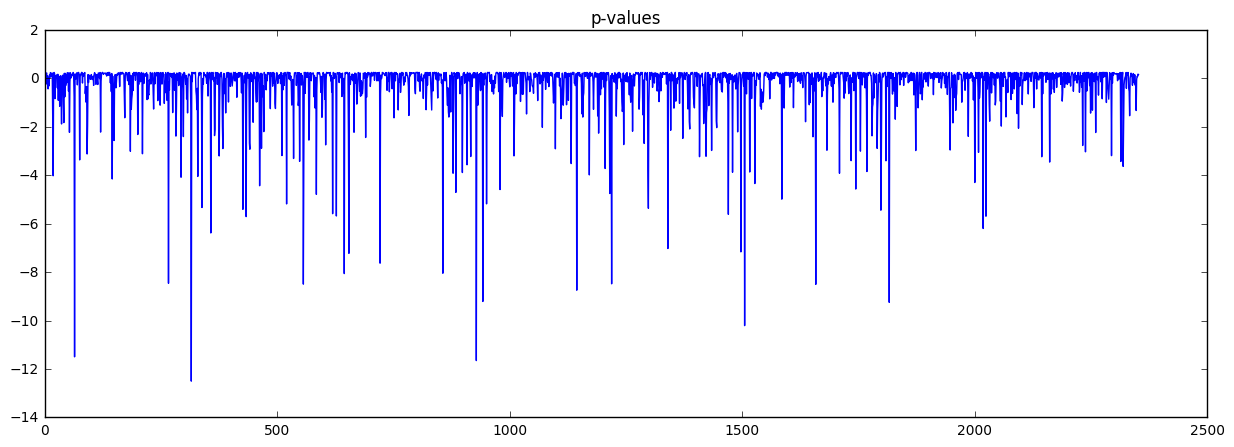

In [38]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print mean
print cov
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [39]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
v2_true_anomalies = np.where(validation2_labels[:,0]==1)
print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
v2_thresholds =v2_p_values[v2_true_anomalies]
print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
print "Test. Location of anomalies: %s"%(test_true_anomalies)
print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
test_thresholds = test_p_values[test_true_anomalies]
print "Test. p-values at true anomalies: %s"%(test_thresholds)





Validation2. Number True Anomalies: 2
Validation2. Location of anomalies: [ 22 521]
validation2. True anomalies: [ 25.1033  19.165 ]
validation2. p-values at true anomalies: [-1872.06705838  -942.75087307]

Test. Number True Anomalies in: 2
Test. Location of anomalies: [ 22 521]
Test. True anomalies: [ 25.1033  19.165 ]
Test. p-values at true anomalies: [-1872.06705838  -942.75087307]


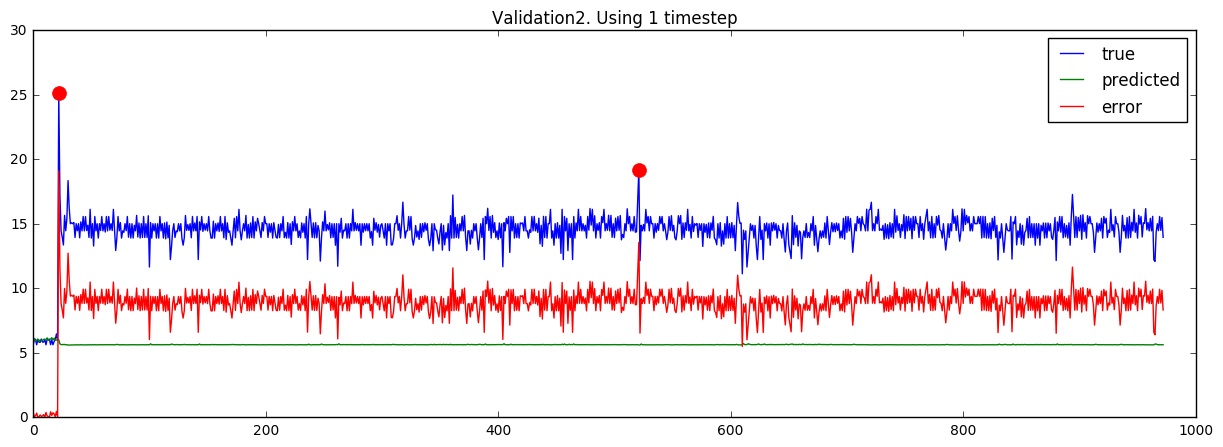

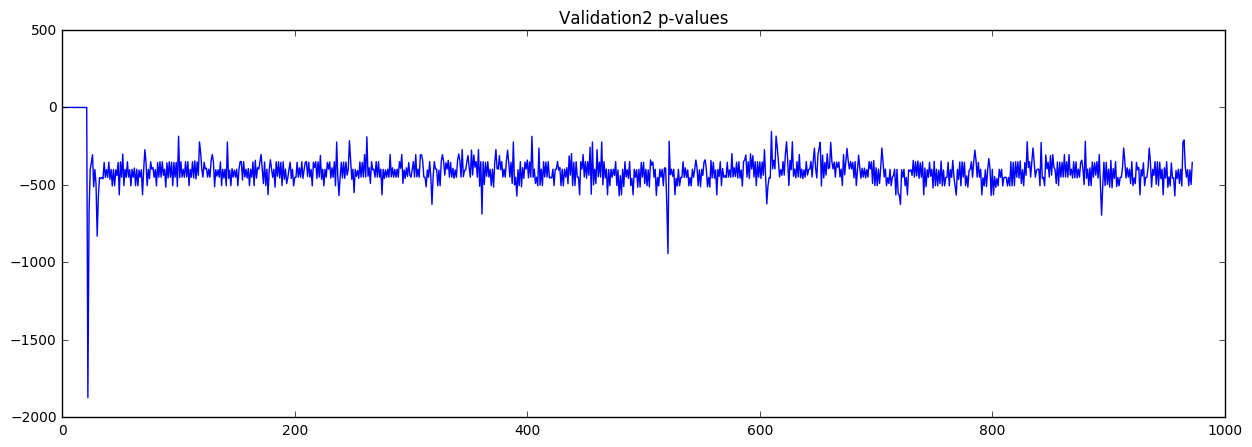

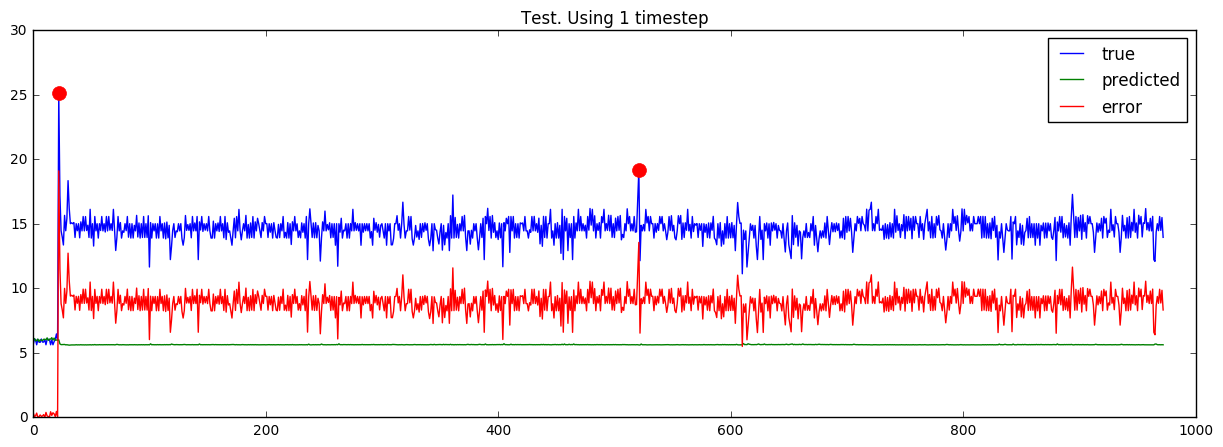

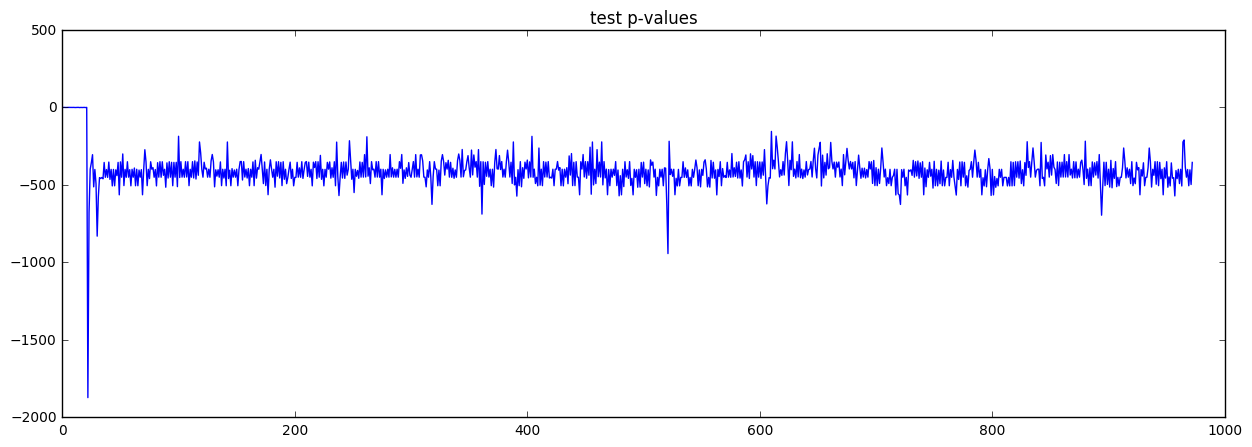

In [40]:
plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,0],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(v2_p_values)
plt.title("Validation2 p-values")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,0],label='predicted')
plt.plot(abs(test_true - test_predictions[:,0]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_p_values)
plt.title("test p-values")
plt.show()


Candidate Thresholds: [-900]


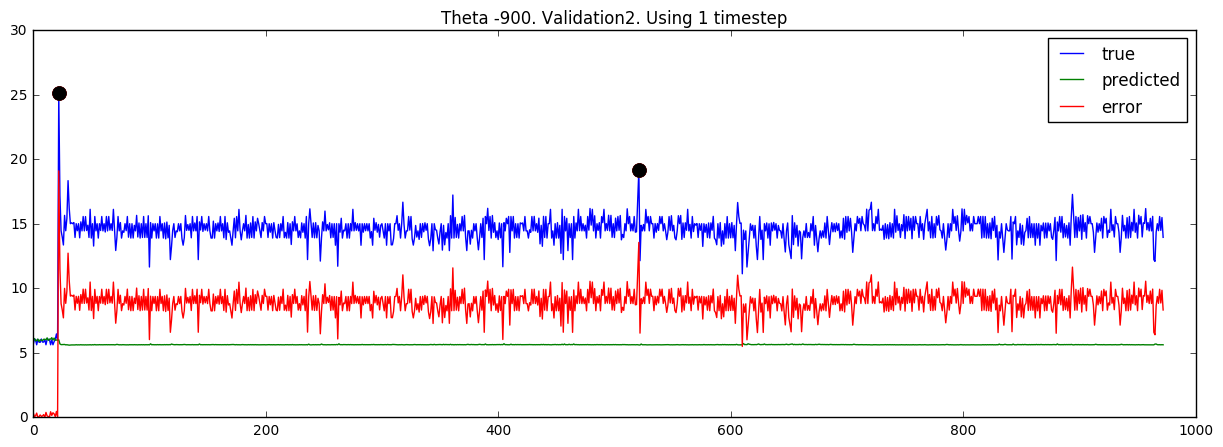

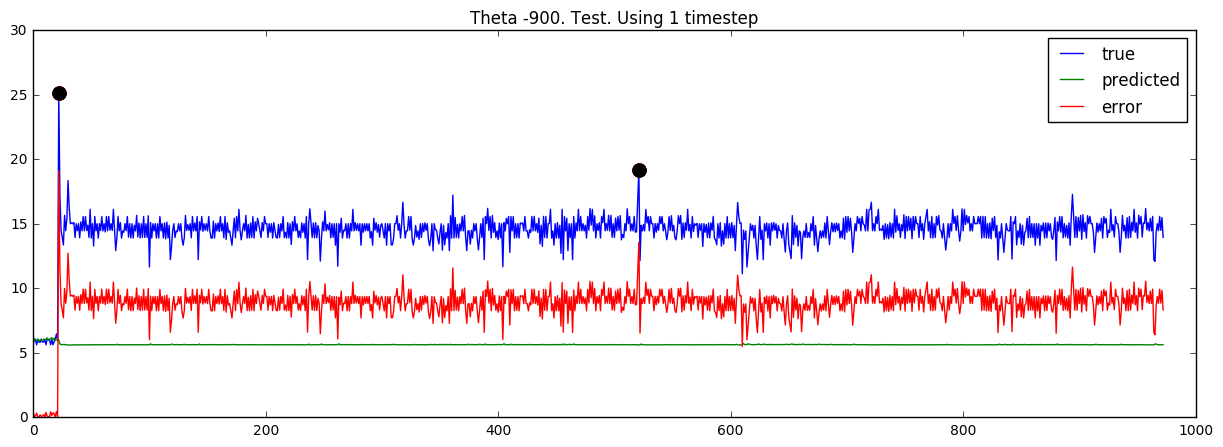

In [41]:
#thresholds = np.append(v2_thresholds,test_thresholds)

#thresholds =v2_thresholds
thresholds =[-900]
print
print "Candidate Thresholds: %s"%(thresholds)


for i in thresholds:
    theta= i
    test_potential_anomalies = np.where(test_p_values <= theta)
    v2_potential_anomalies = np.where(v2_p_values <= theta)
    plt.figure(figsize=(15,5))
    plt.plot(validation2_true,label='true')
    plt.plot(validation2_predictions[:,0],label='predicted')
    plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
    for row in v2_true_anomalies:
        plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
    for row in v2_potential_anomalies:
        plt.plot(row, validation2_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Validation2. Using 1 timestep"%(i))
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_true,label='true')
    plt.plot(test_predictions[:,0],label='predicted')
    plt.plot(abs(test_true - test_predictions[:,0]),label='error')
    for row in test_true_anomalies:
        plt.plot(row, test_true[row], 'r.', markersize=20.0)
    for row in test_potential_anomalies:
        plt.plot(row, test_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Test. Using 1 timestep"%(i))
    plt.show()





In [44]:
theta= -900
test_predicted_anomalies = test_p_values <= theta
v2_predicted_anomalies = [1 if x <= theta else 0 for x in v2_p_values]
print np.shape(validation2_labels)
print fbeta_score(validation2_labels[:,0],v2_predicted_anomalies,pos_label=1, average='binary', beta=.1)
print 

(973, 1)
1.0



(2353, 1)
[ 0.00941006]
()
[ 1.26432788  1.17233323  1.05109568 ...,  1.07441247  1.19238894
  1.16980347]
(2353,)


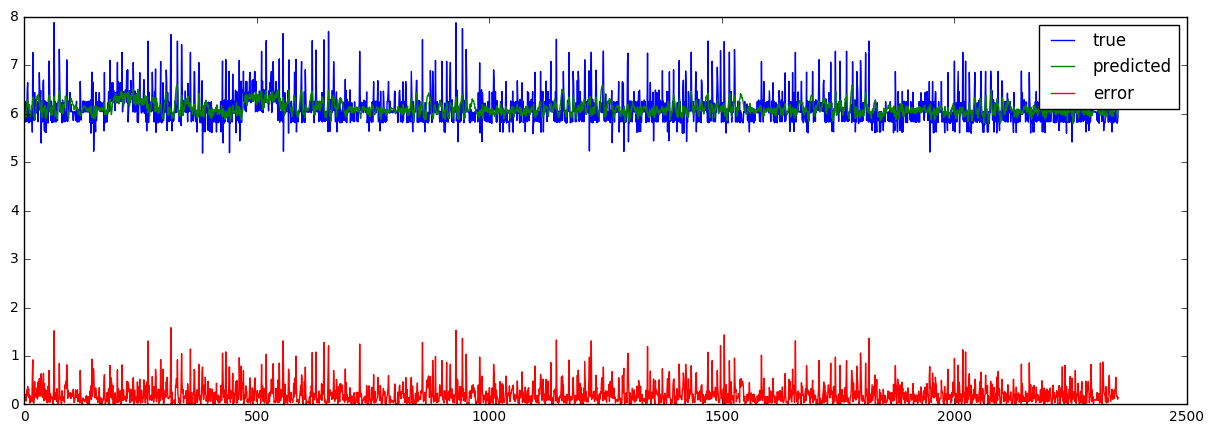

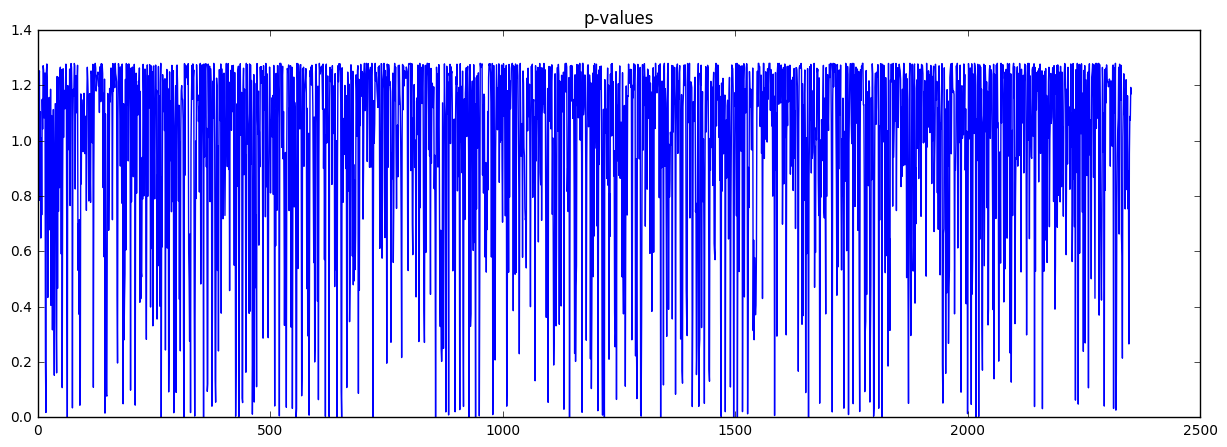

In [15]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]
# print validation2_predictions[100:102]
# print validation2_true[100:102]
# print v2_error_vectors[100:102]
print np.shape(train_error_vectors)
mean = np.mean(train_error_vectors, axis=0)
print mean
cov = np.cov(train_error_vectors,rowvar=False)
print np.shape(cov)
p_values= multivariate_normal.pdf(train_error_vectors,mean,cov)
print p_values
print np.shape(p_values)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

In [16]:
print validation2_predictions[100]
print validation2_true[100]

[ 5.61934614]
11.6467


In [17]:
print validation2_predictions[100] - validation2_true[100]

[-6.02735376]


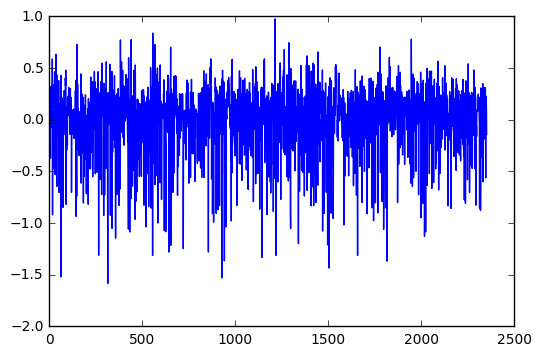

In [18]:
#using prediction intervals
#use first timestep
from scipy.stats import t
p = 95
alpha = (100-p)/100

train_errors = train_predictions[:,0] - train_true
n = np.shape(train_errors)[0]
s =  np.std(train_errors)
plt.plot(train_errors)
plt.show()
